In [1]:
import os
import seaborn as sns
import torch
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.utilities.model_summary import ModelSummary
from lightning_fabric.utilities.seed import seed_everything

In [2]:
torch.set_float32_matmul_precision('high')

In [3]:
%load_ext autoreload

In [4]:
%autoreload
from cellnet.estimators import EstimatorCellTypeClassifier

# Init model

In [5]:
# config parameters
MODEL = 'cellnet_simple'
CHECKPOINT_PATH = os.path.join('/lustre/scratch/users/felix.fischer/tb_logs', MODEL)
LOGS_PATH = os.path.join('/lustre/scratch/users/felix.fischer/tb_logs', MODEL)
DATA_PATH = '/lustre/scratch/users/felix.fischer/merlin_cxg_simple_norm_parquet'


estim = EstimatorCellTypeClassifier(DATA_PATH)
seed_everything(1)
estim.init_datamodule(batch_size=4096)
estim.init_trainer(
    trainer_kwargs={
        'max_epochs': 1000,
        'gradient_clip_val': 1.,
        'gradient_clip_algorithm': 'norm',
        'default_root_dir': CHECKPOINT_PATH,
        'accelerator': 'gpu',
        'devices': 1,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 1,
        'logger': [TensorBoardLogger(LOGS_PATH, name='default')],
        'log_every_n_steps': 100,
        'detect_anomaly': False,
        'enable_progress_bar': True,
        'enable_model_summary': False,
        'enable_checkpointing': True,
        'callbacks': [
            TQDMProgressBar(refresh_rate=50),
            LearningRateMonitor(logging_interval='step'),
            ModelCheckpoint(filename='val_f1_macro_{epoch}_{val_f1_macro:.3f}', monitor='val_f1_macro', mode='max',
                            every_n_epochs=1, save_top_k=2),
            ModelCheckpoint(filename='val_loss_{epoch}_{val_loss:.3f}', monitor='val_loss', mode='min',
                            every_n_epochs=1, save_top_k=2)
        ],
    }
)
estim.init_model(
    model_type='tabnet',
    model_kwargs={
        'learning_rate': 0.03,
        'weight_decay': 0.1,
        'lr_scheduler': torch.optim.lr_scheduler.StepLR,
        'lr_scheduler_kwargs': {
            'step_size': 3,
            'gamma': 0.9,
            'verbose': True
        },
        'optimizer': torch.optim.AdamW,
        'lambda_sparse': 1e-5,
        'n_d': 64,
        'n_a': 32,
        'n_steps': 3,
        'gamma': 1.3,
        'n_independent': 7,
        'n_shared': 3,
        'virtual_batch_size': 256,
        'mask_type': 'entmax',
    },
)
print(ModelSummary(estim.model))


[rank: 0] Global seed set to 1
/home/icb/felix.fischer/Programs/anaconda3/envs/merlin/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/felix.fischer/Programs/anaconda3/envs/merl ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | ce_loss       | CrossEntropyLoss | 0     
4 | parent_lookup | Embedding        | 16.4 K
5 | child_lookup  | Embedding        | 16.4 K
6 | classifier    | TabNet           | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
32.8 K    Non-trainable params
6.4 M     Total params
25.511    Total estimated model params size (MB)


# Find learning rate

In [6]:
lr_find_res = estim.find_lr(lr_find_kwargs={'early_stop_threshold': 10., 'min_lr': 1e-8, 'max_lr': 10., 'num_training': 120})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adjusting learning rate of group 0 to 2.0000e-02.


Finding best initial lr:   0%|          | 0/120 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=120` reached.
Restoring states from the checkpoint path at /lustre/scratch/users/felix.fischer/tb_logs/cellnet_simple/.lr_find_26c8b2da-c6ed-46f0-bc7e-1f3fe3190356.ckpt
Restored all states from the checkpoint file at /lustre/scratch/users/felix.fischer/tb_logs/cellnet_simple/.lr_find_26c8b2da-c6ed-46f0-bc7e-1f3fe3190356.ckpt


Suggested learning rate: 0.06683439175686143


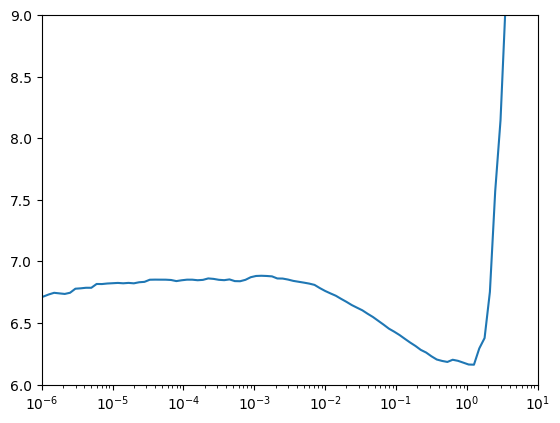

In [7]:
ax = sns.lineplot(x=lr_find_res[1]['lr'], y=lr_find_res[1]['loss'])
ax.set_xscale('log')
ax.set_ylim(6., top=9.)
ax.set_xlim(1e-6, 10.)
print(f'Suggested learning rate: {lr_find_res[0]}')

# Fit model

In [ ]:
estim.train()